In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
!pip install ucimlrepo


## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

### ⚡ Zaimplementuj tutaj perceptron

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

bank_marketing_df = pd.concat([X, y], axis=1)
bank_marketing_df = bank_marketing_df.convert_dtypes()
bank_marketing_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,<NA>,5,may,261,1,-1,0,<NA>,no
1,44,technician,single,secondary,no,29,yes,no,<NA>,5,may,151,1,-1,0,<NA>,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,<NA>,5,may,76,1,-1,0,<NA>,no
3,47,blue-collar,married,<NA>,no,1506,yes,no,<NA>,5,may,92,1,-1,0,<NA>,no
4,33,<NA>,single,<NA>,no,1,no,no,<NA>,5,may,198,1,-1,0,<NA>,no


In [ ]:
kolumny_binarne = ['loan', 'housing','y']

bank_marketing_df[kolumny_binarne] = bank_marketing_df[kolumny_binarne].replace({
    'yes': '1',
    'no': '0'
})

In [ ]:
bank_marketing_df = bank_marketing_df.convert_dtypes()
bank_marketing_df[kolumny_binarne] = bank_marketing_df[kolumny_binarne].astype(int)

In [ ]:

bank_marketing_df['has_loan'] = bank_marketing_df.apply(lambda x: 1 if x['housing'] > 0 or x['loan'] > 0 else 0, axis=1)

selected_features = ['balance', 'age','has_loan']
X_data = bank_marketing_df[selected_features]
y_data = bank_marketing_df['y']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.2,
    random_state=42,
    stratify=y_data
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)

X_train = X_train.astype(int)
X_val = X_val.astype(int)
X_test = X_test.astype(int)


In [ ]:
scaler = StandardScaler().set_output(transform="pandas")

X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train.head()

,balance,age,has_loan
10333,0.359448,0.198030,0.780196
9723,-0.224158,-0.084115,-1.281729
22764,0.795696,-0.178164,0.780196
23223,-0.338159,0.103982,0.780196
5594,-0.238732,-0.930553,0.780196


Jesli mozna zostawic dwie cechy to z shapa wezmiemy balance i age jak on i tak na nich sie opiera

Trzeba uzyc sigmoid poniewaz da nam prawdopodobienstwo w zakresie  0,1 a relu da 0 lub po prostu liczbe co dla nas nie ma sensu bo szukamy prawdopodobienstwa dla dalszej klasyfikacji

In [ ]:
class Perceptron:

  def __init__(self):
    pass

  def forward(self, X: np.ndarray, W: np.ndarray , b):
    #W = W.T
    Z = np.dot(X, W) + b
    A = self.activation(Z)
    return A


  def activation(self, Z: np.ndarray):
    A = (1/(1+np.exp(-Z)))
    return A

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1) # Upewniamy się, że to wektor kolumnowy
X_val = np.array(X_val)
y_val = np.array(y_val).reshape(-1, 1)

In [ ]:
class Trainer:

  def __init__(self, perceptron: Perceptron, batch_size, n_epochs: int, a:float):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.a = a

    self.W = None
    self.b = 0.0

    self.batch_size = batch_size
    self.history = {'train_loss': [],'val_loss': [], 'train_acc': [],'val_acc': []}

  def loss(self, A: np.array, y: np.ndarray ): # oblicza stratę między wyjściem sieci a ground truth
    L = -(1/A.shape[0]) * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    return L

  def backward(self, X: np.ndarray, A: np.array, y:np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne

    Bp = (1/A.shape[0]) * X.T @ (A-y)
    return Bp

  def update_weights(self): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    self.W = self.W - self.a * self.Bp
    return None

  def accuracy(self, A, y):

        predictions = (A > 0.5).astype(int)
        return np.mean(predictions == y)

  def train(self,X_train, y_train,X_val,y_val): # wykonuje trenowanie w N epokach

    n = X_train.shape[0] #ilosc probek

    self.W = np.random.uniform(-0.01, 0.01, (X_train.shape[1], 1))
    ind = np.arange(n)

    for epoch in range(self.n_epochs):
      np.random.shuffle(ind) #tasujemy nuggetsy

      for i in range(0, n, self.batch_size):

        batch_ind = ind[i:i+self.batch_size]
        X_batch = X_train[batch_ind]
        y_batch = y_train[batch_ind]

        A = self.perceptron.forward(X_batch, self.W, self.b)
        self.Bp = self.backward(X_batch, A, y_batch)
        self.update_weights()

      A_train = self.perceptron.forward(X_train, self.W, self.b)
      loss_train = self.loss(A_train, y_train)
      acc_train = self.accuracy(A_train, y_train)

      A_val = self.perceptron.forward(X_val, self.W, self.b)
      loss_val = self.loss(A_val, y_val)
      acc_val = self.accuracy(A_val, y_val)

      self.history['train_loss'].append(loss_train)
      self.history['val_loss'].append(loss_val)
      self.history['train_acc'].append(acc_train)
      self.history['val_acc'].append(acc_val)

      if epoch % 10 == 0:
          print(f"Epoka {epoch}: Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}")
    return None

  def plot_maker (self):
        epochs = range(len(self.history['train_loss']))
        plt.figure(figsize=(12, 5))

        # Wykres Straty (Loss)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Strata Treningowa')
        plt.plot(epochs, self.history['val_loss'], label='Strata Walidacyjna', linestyle='--')
        plt.title('Krzywa uczenia (Loss)')
        plt.xlabel('Epoki')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Wykres Dokładności (Accuracy)
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], label='Dokładność Treningowa')
        plt.plot(epochs, self.history['val_acc'], label='Dokładność Walidacyjna', linestyle='--')
        plt.title('Dokładność modelu (Accuracy)')
        plt.xlabel('Epoki')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.show()

        return None

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X, self.W, self.b)
    return A


BCE 😢 X(A-G)?

## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

Epoka 0: Train Loss=0.6883, Val Loss=0.6879
Epoka 10: Train Loss=0.6882, Val Loss=0.6880
Epoka 20: Train Loss=0.6880, Val Loss=0.6876
Epoka 30: Train Loss=0.6882, Val Loss=0.6878
Epoka 40: Train Loss=0.6892, Val Loss=0.6889
Epoka 50: Train Loss=0.6890, Val Loss=0.6886
Epoka 60: Train Loss=0.6885, Val Loss=0.6881
Epoka 70: Train Loss=0.6879, Val Loss=0.6875
Epoka 80: Train Loss=0.6878, Val Loss=0.6875
Epoka 90: Train Loss=0.6880, Val Loss=0.6876
Epoka 100: Train Loss=0.6879, Val Loss=0.6876
Epoka 110: Train Loss=0.6880, Val Loss=0.6876
Epoka 120: Train Loss=0.6884, Val Loss=0.6880
Epoka 130: Train Loss=0.6878, Val Loss=0.6875
Epoka 140: Train Loss=0.6880, Val Loss=0.6877
Epoka 150: Train Loss=0.6888, Val Loss=0.6883
Epoka 160: Train Loss=0.6895, Val Loss=0.6892
Epoka 170: Train Loss=0.6882, Val Loss=0.6878
Epoka 180: Train Loss=0.6880, Val Loss=0.6876
Epoka 190: Train Loss=0.6883, Val Loss=0.6880
Epoka 200: Train Loss=0.6879, Val Loss=0.6876
Epoka 210: Train Loss=0.6885, Val Loss=0.6882

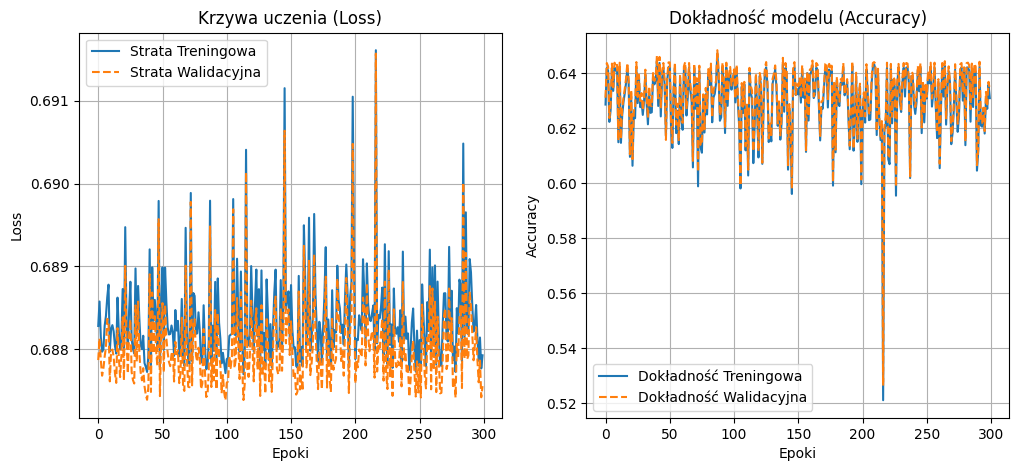

In [ ]:
perceptron = Perceptron()
trainer = Trainer(perceptron, batch_size=32, n_epochs=300, a = 0.1)
trainer.train(X_train, y_train, X_val, y_val)
trainer.plot_maker()

Epoka 0: Train Loss=0.6878, Val Loss=0.6875
Epoka 10: Train Loss=0.6877, Val Loss=0.6874
Epoka 20: Train Loss=0.6877, Val Loss=0.6874
Epoka 30: Train Loss=0.6877, Val Loss=0.6874
Epoka 40: Train Loss=0.6877, Val Loss=0.6874
Epoka 50: Train Loss=0.6877, Val Loss=0.6874
Epoka 60: Train Loss=0.6877, Val Loss=0.6874
Epoka 70: Train Loss=0.6877, Val Loss=0.6874
Epoka 80: Train Loss=0.6877, Val Loss=0.6874
Epoka 90: Train Loss=0.6877, Val Loss=0.6874
Epoka 100: Train Loss=0.6877, Val Loss=0.6874
Epoka 110: Train Loss=0.6877, Val Loss=0.6874
Epoka 120: Train Loss=0.6877, Val Loss=0.6874
Epoka 130: Train Loss=0.6877, Val Loss=0.6874
Epoka 140: Train Loss=0.6877, Val Loss=0.6874
Epoka 150: Train Loss=0.6877, Val Loss=0.6874
Epoka 160: Train Loss=0.6877, Val Loss=0.6874
Epoka 170: Train Loss=0.6877, Val Loss=0.6874
Epoka 180: Train Loss=0.6877, Val Loss=0.6874
Epoka 190: Train Loss=0.6877, Val Loss=0.6874


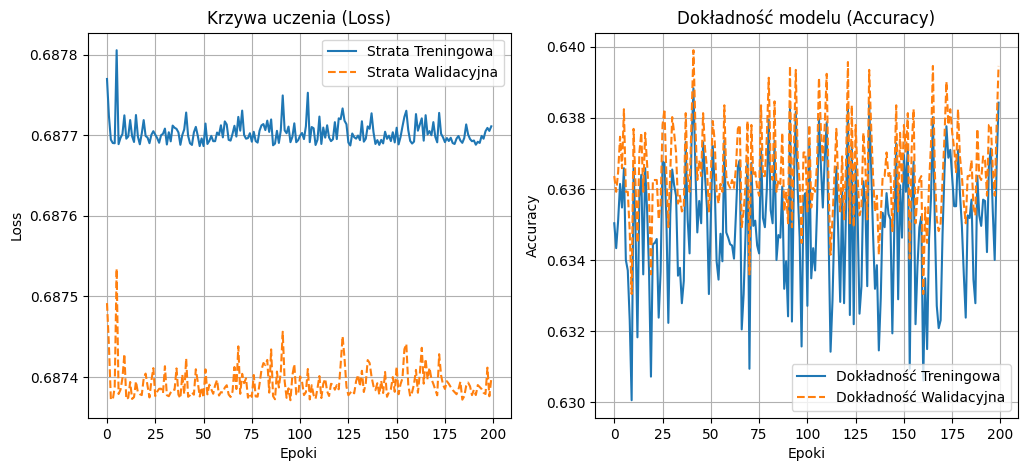

In [ ]:
perceptron = Perceptron()
trainer = Trainer(perceptron, batch_size=32, n_epochs=200, a = 0.01)
trainer.train(X_train, y_train, X_val, y_val)
trainer.plot_maker()

Epoka 0: Train Loss=0.6893, Val Loss=0.6890
Epoka 10: Train Loss=0.6881, Val Loss=0.6878
Epoka 20: Train Loss=0.6893, Val Loss=0.6890
Epoka 30: Train Loss=0.6885, Val Loss=0.6881
Epoka 40: Train Loss=0.6884, Val Loss=0.6882
Epoka 50: Train Loss=0.6882, Val Loss=0.6878
Epoka 60: Train Loss=0.6881, Val Loss=0.6878
Epoka 70: Train Loss=0.6879, Val Loss=0.6876
Epoka 80: Train Loss=0.6878, Val Loss=0.6875
Epoka 90: Train Loss=0.6877, Val Loss=0.6874


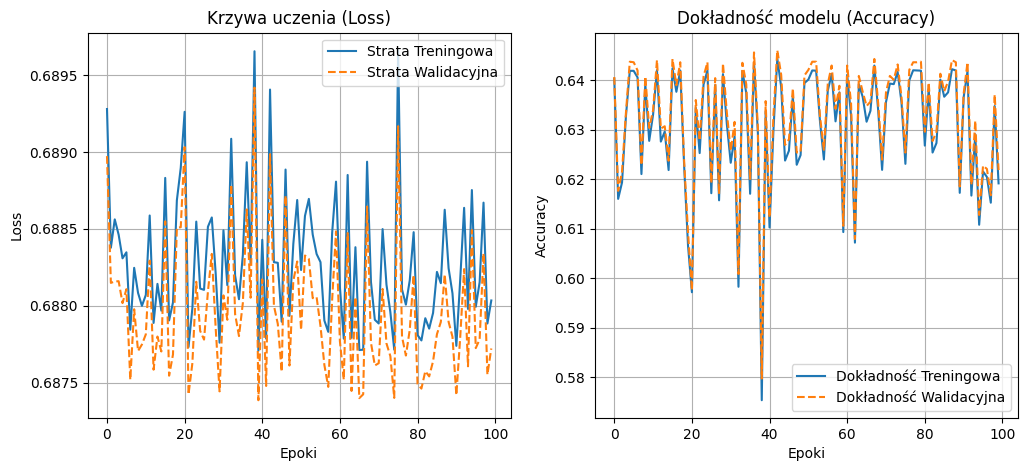

In [ ]:
perceptron = Perceptron()
trainer = Trainer(perceptron, batch_size=32, n_epochs=100, a = 0.1)
trainer.train(X_train, y_train, X_val, y_val)
trainer.plot_maker()

magiczna liczba  0.69
tu chyba dobrze widac dlaczego jeden jedyny neuron to za malo dla tak poplatanych korelacji XD
za glupi jest lub model lub ja (w rzeczywstosci oba)
niedouczony biedak
procenty dokladnosci sa na poziomie po prostu podzialu tak/nie dla y

## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [ ]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

W numpy za duzo pierdolenia sie to odpowiedz 😿

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


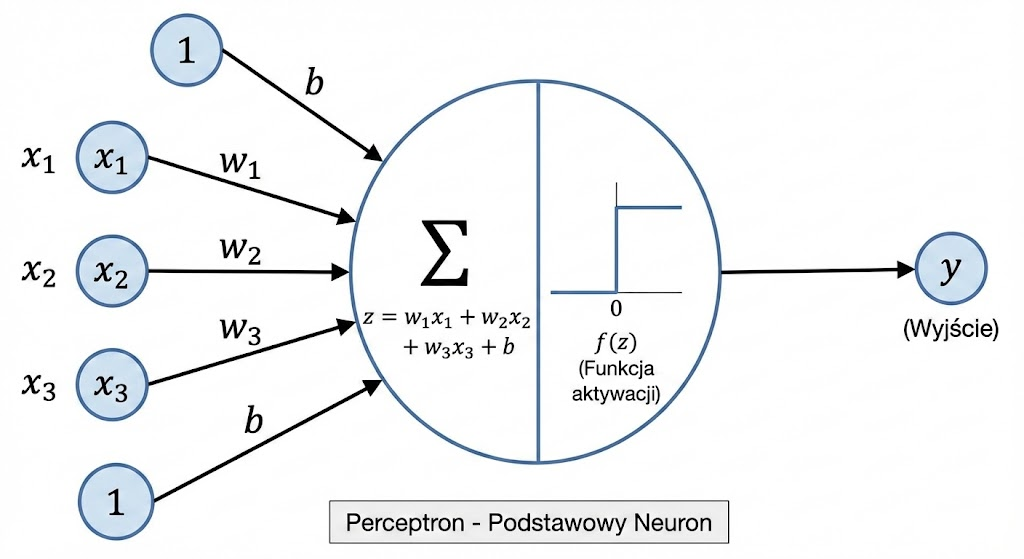